In [1]:
import os
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import kagglehub

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    print('TPU initialized')
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    print('No TPU devices found, using GPU instead.')
    strategy = tf.distribute.MirroredStrategy()

dataset_path = kagglehub.dataset_download("gpiosenka/time-image-datasetclassification")
print("Path to dataset files:", dataset_path)

train_dir = os.path.join(dataset_path, 'train')
valid_dir = os.path.join(dataset_path, 'valid')
test_dir = os.path.join(dataset_path, 'test')

AUTOTUNE = tf.data.experimental.AUTOTUNE

def augment_image(image):
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.5, upper=1.5)
    image = tf.image.random_hue(image, max_delta=0.05)
    image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
    return image

def load_image(path, augment=False):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    img = img / 255.0

    if augment:
        img = augment_image(img)

    return img

def get_label(file_path, class_to_index):
    parts = tf.strings.split(file_path, os.path.sep)
    label = parts[-2]
    return class_to_index.lookup(label)

def create_dataset(directory, batch_size=32, augment=False):
    class_names = sorted(os.listdir(directory))
    class_to_index = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(
            keys=tf.constant(class_names),
            values=tf.constant(list(range(len(class_names))), dtype=tf.int32)
        ),
        default_value=-1
    )

    def process_path(path):
        image = load_image(path, augment)
        label = get_label(path, class_to_index)
        return image, label

    dataset = tf.data.Dataset.list_files(os.path.join(directory, '*/*.jpg'))
    dataset = dataset.map(process_path, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    return dataset


train_dataset = create_dataset(train_dir, augment=True)
valid_dataset = create_dataset(valid_dir, augment=False)
test_dataset = create_dataset(test_dir, augment=False)

from tensorflow.keras.applications import EfficientNetB0

# Загружаем модель EfficientNetB0
with strategy.scope():
    base_model = EfficientNetB0(weights=None, include_top=False, input_shape=(224, 224, 3))

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(144, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=x)

    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

checkpoint_callback = ModelCheckpoint(
    'best_efficientnet_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

history = model.fit(
    train_dataset,
    epochs=40,
    validation_data=valid_dataset,
    callbacks=[checkpoint_callback]
)

test_loss, test_acc = model.evaluate(test_dataset)
print(f'Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}')


TPU initialized
Path to dataset files: /root/.cache/kagglehub/datasets/gpiosenka/time-image-datasetclassification/versions/5
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                    

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


360/360 [==============================] - 161s 179ms/step - loss: 4.8573 - accuracy: 0.0122 - val_loss: 5.4631 - val_accuracy: 0.0069
Epoch 2/40
360/360 [==============================] - ETA: 0s - loss: 3.6531 - accuracy: 0.1242
Epoch 2: val_accuracy improved from 0.00694 to 0.36042, saving model to best_efficientnet_model.h5
360/360 [==============================] - 51s 139ms/step - loss: 3.6531 - accuracy: 0.1242 - val_loss: 2.2497 - val_accuracy: 0.3604
Epoch 3/40
360/360 [==============================] - ETA: 0s - loss: 1.4360 - accuracy: 0.5888
Epoch 3: val_accuracy improved from 0.36042 to 0.91806, saving model to best_efficientnet_model.h5
360/360 [==============================] - 51s 140ms/step - loss: 1.4360 - accuracy: 0.5888 - val_loss: 0.2853 - val_accuracy: 0.9181
Epoch 4/40
360/360 [==============================] - ETA: 0s - loss: 0.5034 - accuracy: 0.8625
Epoch 4: val_accuracy improved from 0.91806 to 0.98403, saving model to best_efficientnet_model.h5
360/360 [===

1/1 [==============================] - 4s 4s/step
True Labels:       ['3-30', '7-25', '2-20', '9-30', '9-35', '10-55', '1-50', '3-10', '11-10', '5-00', '3-20', '6-50', '11-10', '10-05', '8-25', '1-55', '2-05', '4-50', '10-30', '4-45', '4-10', '7-55', '4-15', '1-35', '3-05', '8-25', '11-50', '10-50', '2-55', '12-05', '12-35', '12-50']
Predicted Labels:  ['3-30', '7-25', '2-20', '9-30', '9-35', '10-55', '1-50', '3-10', '11-10', '5-00', '3-20', '6-50', '11-10', '10-05', '8-25', '1-55', '2-05', '4-50', '10-30', '4-45', '4-10', '7-55', '4-15', '1-35', '3-05', '8-25', '11-50', '10-50', '2-55', '12-05', '12-35', '12-50']


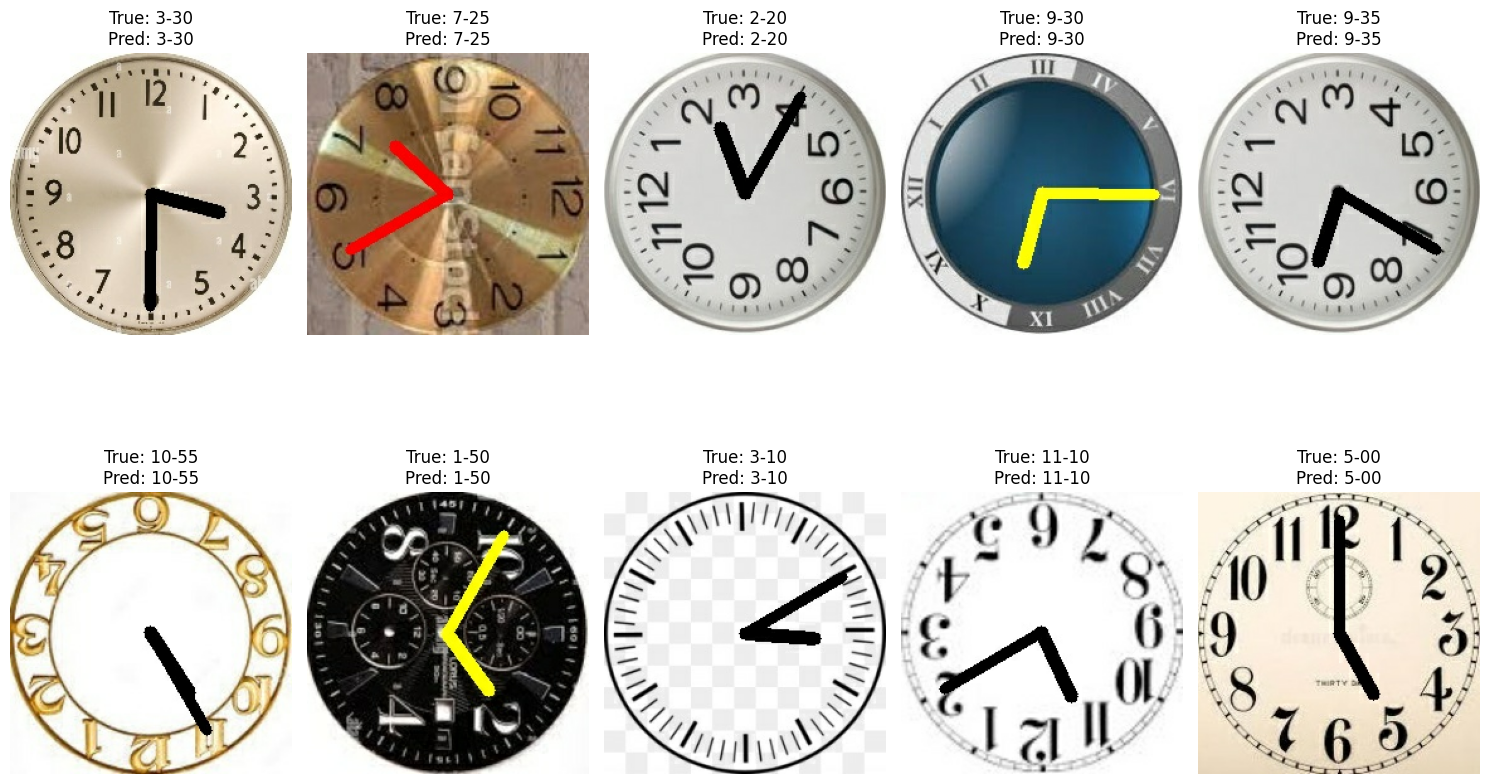

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

class_names = sorted(os.listdir(test_dir))
index_to_class = {idx: name for idx, name in enumerate(class_names)}

model = tf.keras.models.load_model('best_efficientnet_model.h5')

for images, labels in test_dataset.take(1):
    images = images.numpy()
    labels = labels.numpy()

predictions = model.predict(images)
predicted_indices = np.argmax(predictions, axis=1)

true_labels = [index_to_class[idx] for idx in labels]
predicted_labels = [index_to_class[idx] for idx in predicted_indices]

print("True Labels:      ", true_labels)
print("Predicted Labels: ", predicted_labels)

plt.figure(figsize=(15, 10))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])
    plt.title(f"True: {true_labels[i]}\nPred: {predicted_labels[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()
